# Semi-Supervised Learning for Instance Segmentation

## Introduction

Semi-supervised learning (SSL) is a machine learning paradigm that leverages both labeled and unlabeled data to improve model performance, especially when labeled data is scarce. In segmentation tasks, SSL methods help in learning better representations by utilizing the abundance of unlabeled images. This notebook implements SSL techniques for instance segmentation on the Dresden Surgical Anatomy Dataset using YOLOv12-Seg as the baseline model.

## Dataset Description & Splitting Strategy

The Dresden Surgical Anatomy Dataset is used for instance segmentation of surgical anatomy. The dataset is split as follows:
- 80% Training (further split into 20% labeled and 80% unlabeled)
- 10% Validation
- 10% Testing

Image counts after splitting will be displayed in the code.

**Group Members**
1. Asfar Hossain Sitab (2022-3-60-275)
2. Parmita Hossain Simia (2022-3-60-253)
3. Kamran Hasan (2022-2-60-077)
4. Nusrat Jahan Oishi (2022-2-60-033)

In [21]:
# Install dependencies
!pip install --upgrade ultralytics --no-deps

from ultralytics import YOLO
import os, yaml, shutil, random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import albumentations as A
dataset_path = '/kaggle/input/the-dresden-surgical-anatomy-dataset/Dresden Dataset'

with open(os.path.join(dataset_path, 'dataset.yaml'), 'r') as f:
    data_yaml = yaml.safe_load(f)

print("Dataset loaded.")


Dataset loaded.


In [24]:
images_dir = os.path.join(dataset_path, 'images')
labels_dir = os.path.join(dataset_path, 'labels')

all_images = [f for f in os.listdir(os.path.join(images_dir, 'train'))
              if f.endswith(('.jpg', '.png'))]

train_images, temp = train_test_split(all_images, test_size=0.2, random_state=42)
val_images, test_images = train_test_split(temp, test_size=0.5, random_state=42)
labeled_images, unlabeled_images = train_test_split(train_images, test_size=0.8, random_state=42)

splits = {'train': train_images, 'val': val_images, 'test': test_images, 'labeled': labeled_images}

for split, imgs in splits.items():
    os.makedirs(f'/kaggle/working/images/{split}', exist_ok=True)
    os.makedirs(f'/kaggle/working/labels/{split}', exist_ok=True)
    for img in imgs:
        shutil.copy(os.path.join(images_dir, 'train', img),
                    f'/kaggle/working/images/{split}/{img}')
        lbl = img.replace('.jpg', '.txt').replace('.png', '.txt')
        if os.path.exists(os.path.join(labels_dir, 'train', lbl)):
            shutil.copy(os.path.join(labels_dir, 'train', lbl),
                        f'/kaggle/working/labels/{split}/{lbl}')

os.makedirs('/kaggle/working/images/unlabeled', exist_ok=True)
for img in unlabeled_images:
    shutil.copy(os.path.join(images_dir, 'train', img),
                f'/kaggle/working/images/unlabeled/{img}')


In [25]:
data_yaml_labeled = {
    'path': '/kaggle/working',
    'train': '/kaggle/working/images/labeled',
    'val': '/kaggle/working/images/val',
    'test': '/kaggle/working/images/test',
    'nc': 11,
    'names': data_yaml['names']
}

with open('/kaggle/working/data_labeled.yaml', 'w') as f:
    yaml.dump(data_yaml_labeled, f)

data_yaml_combined = data_yaml_labeled.copy()
data_yaml_combined['train'] = '/kaggle/working/images/train'

with open('/kaggle/working/data_combined.yaml', 'w') as f:
    yaml.dump(data_yaml_combined, f)


## Model Overview

**Baseline Model:** YOLOv12-Seg trained only on 20% labeled data.

**SSL Methods:**
1. **Pseudo-Labeling:** Generate pseudo-labels on unlabeled data using baseline, then retrain on labeled + pseudo-labeled.
2. **Mean Teacher:** Use exponential moving average (EMA) of model weights for consistency.
3. **FixMatch:** Apply weak/strong augmentations and consistency loss.

All methods use both labeled and unlabeled data.

In [32]:
model_baseline = YOLO('yolo12n-seg.yaml').load('yolo12n.pt')

model_baseline.train(
    data='/kaggle/working/data_labeled.yaml',
    epochs=20,
    imgsz=416,
    batch=4,
    device=0,
    project='runs',
    name='baseline',
    exist_ok=True
)


Transferred 691/753 items from pretrained weights
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=baseline, nbs=64, nms=False, opset=None, optimize=False, optimizer=aut

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1736       2853      0.507      0.515      0.483      0.313      0.514      0.508      0.486      0.282
        abdominal_wall        215        317      0.418      0.372      0.358      0.278      0.432       0.36      0.365      0.257
                 colon        187        332      0.393       0.41      0.319      0.224      0.398      0.407      0.322      0.203
inferior_mesenteric_artery        150        204      0.446      0.515      0.475      0.248      0.455      0.515       0.47      0.197
      intestinal_veins        143        219       0.57      0.562      0.553       0.29      0.565      0.543      0.546      0.218
                 liver        194        238      0.755      0.794      0.785      0.623      0.759      0.794      0.794      0.597
              pancreas        136        451       0.47      0.381      0.354       0.17      0.502      0.392      0.371      0.144
       small_intestine        156        268      0.423      0.41

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f87c9322ad0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038

## Mixmatch

In [33]:
K = 2
CONF_THRESHOLD = 0.7

weak_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2)
])

teacher = model_baseline
unlabeled_dir = '/kaggle/working/images/unlabeled'
train_img_dir = '/kaggle/working/images/train'
train_lbl_dir = '/kaggle/working/labels/train'

for img in unlabeled_images:
    img_path = os.path.join(unlabeled_dir, img)
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    preds_all = []

    for _ in range(K):
        aug_img = weak_aug(image=image)['image']
        results = teacher.predict(aug_img, conf=CONF_THRESHOLD, verbose=False)
        if results and results[0].masks is not None:
            preds_all.append(results[0])

    if len(preds_all) == 0:
        continue

    cv2.imwrite(os.path.join(train_img_dir, img),
                cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

    label_path = os.path.join(train_lbl_dir,
                              img.replace('.jpg', '.txt').replace('.png', '.txt'))

    with open(label_path, 'w') as f:
        for pred in preds_all:
            for i in range(len(pred.masks.xyn)):
                cls = int(pred.boxes.cls[i].cpu().numpy())
                polygon = pred.masks.xyn[i].reshape(-1)
                f.write(f"{cls} {' '.join(map(str, polygon))}\n")


In [34]:
model_mixmatch = YOLO('yolo12n-seg.yaml').load('yolo12n.pt')

model_mixmatch.train(
    data='/kaggle/working/data_combined.yaml',
    epochs=20,
    imgsz=416,
    batch=4,
    device=0,
    project='runs',
    name='mixmatch',
    exist_ok=True
)


Transferred 691/753 items from pretrained weights
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data_combined.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=mixmatch, nbs=64, nms=False, opset=None, optimize=False, optimizer=au

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1736       2853      0.663      0.662      0.682      0.473      0.692      0.649      0.689      0.425
        abdominal_wall        215        317      0.483      0.495      0.532      0.431      0.508      0.464      0.537      0.401
                 colon        187        332      0.505      0.488      0.474      0.347       0.53      0.476      0.482      0.329
inferior_mesenteric_artery        150        204      0.717      0.746      0.754      0.449      0.756       0.73      0.753      0.386
      intestinal_veins        143        219      0.766      0.732      0.777      0.476      0.791      0.721      0.774      0.369
                 liver        194        238      0.748      0.861       0.84      0.701      0.762      0.849      0.839      0.629
              pancreas        136        451      0.713      0.452      0.535      0.273      0.749      0.426       0.55      0.244
       small_intestine        156        268      0.513      0.69

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f882c27b090>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038

## Training Plots

Loss and metric curves for all models.

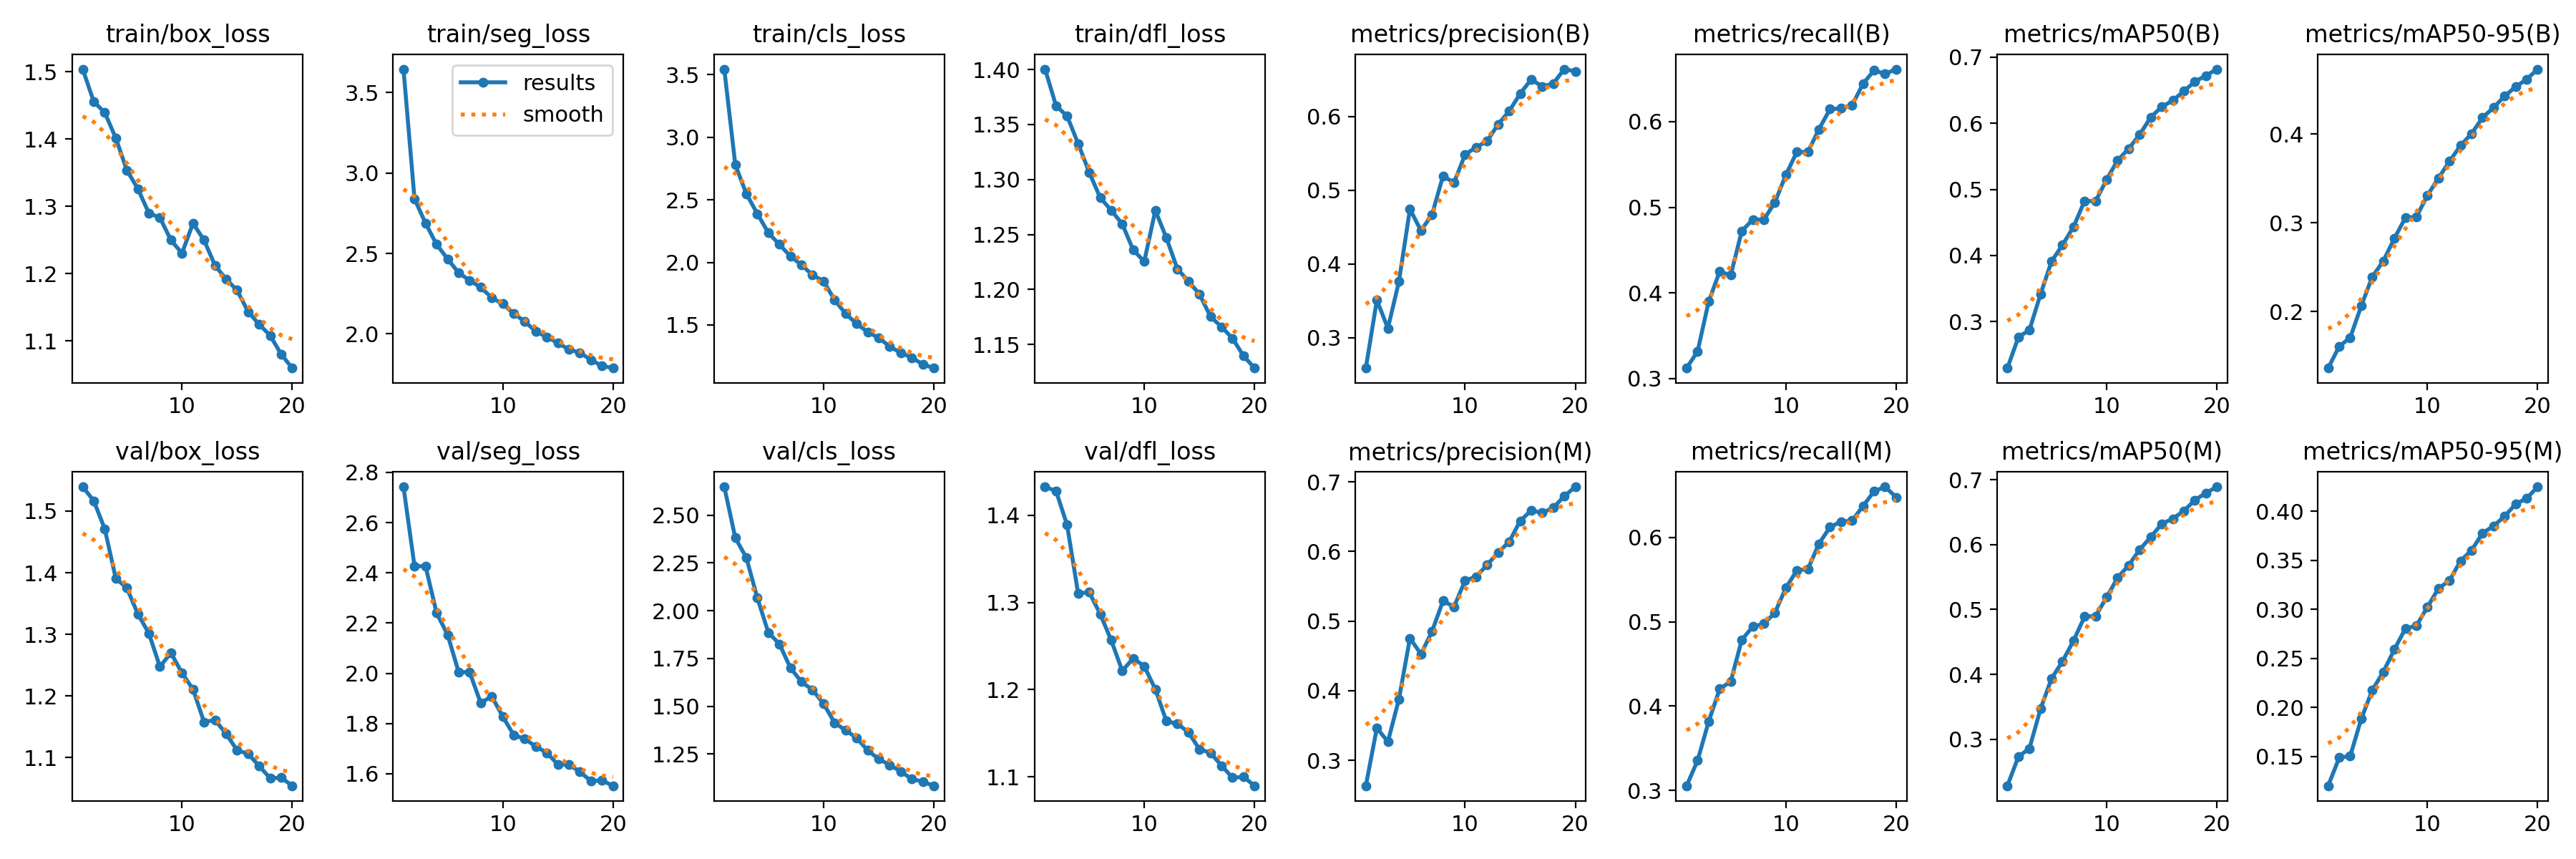

In [35]:
# Plot training results
from IPython.display import Image

# Baseline results
Image('runs/baseline/results.png')

# MixMatch results
Image('runs/mixmatch/results.png')


## Evaluation

In [ ]:
# Evaluation
metrics_baseline = model_baseline.val(data='/kaggle/working/data_labeled.yaml')
metrics_mixmatch = model_mixmatch.val(data='/kaggle/working/data_combined.yaml')

# Extract Baseline mAP
map50_baseline = metrics_baseline.box.map50
map5095_baseline = metrics_baseline.box.map

# Extract MixMatch model mAP
map50_mixmatch = metrics_mixmatch.box.map50
map5095_mixmatch = metrics_mixmatch.box.map

# Print Comparison
print("Evaluation Results:")
print("--------------------")
print("Baseline YOLOv12:")
print(f" - mAP@0.5: {map50_baseline:.4f}")
print(f" - mAP@0.5:0.95: {map5095_baseline:.4f}")

print("\nMixMatch SSL Model:")
print(f" - mAP@0.5: {map50_mixmatch:.4f}")
print(f" - mAP@0.5:0.95: {map5095_mixmatch:.4f}")

print("\nEvaluation Complete.")


Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3364.8±957.4 MB/s, size: 334.4 KB)
val: Scanning /kaggle/working/labels/val.cache... 1736 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1736/1736 3.6Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 109/109 8.3it/s 13.2s0.1ss


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1736       2853      0.506      0.516      0.483      0.313      0.514      0.508      0.485      0.281
        abdominal_wall        215        317      0.415      0.372      0.358      0.278      0.428      0.353      0.365      0.257
                 colon        187        332      0.394      0.413       0.32      0.223      0.397      0.407      0.322      0.203
inferior_mesenteric_artery        150        204      0.446      0.515      0.473      0.248      0.453      0.515      0.468      0.195
      intestinal_veins        143        219      0.568      0.564      0.552      0.291      0.563      0.543      0.546      0.216
                 liver        194        238      0.754      0.794      0.785      0.622       0.76      0.794      0.795      0.596
              pancreas        136        451      0.468      0.381      0.354      0.169      0.499       0.39      0.371      0.144
       small_intestine        156        268      0.425      0.42

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1736       2853      0.662      0.662      0.682      0.473      0.688      0.651      0.689      0.423
        abdominal_wall        215        317      0.484      0.495      0.532      0.431        0.5      0.464      0.537        0.4
                 colon        187        332      0.504      0.488      0.476      0.349      0.531      0.479      0.482      0.328
inferior_mesenteric_artery        150        204      0.711      0.735      0.749      0.446       0.75      0.735      0.757      0.389
      intestinal_veins        143        219      0.766      0.734      0.777      0.474      0.786      0.722      0.774      0.365
                 liver        194        238      0.746      0.861       0.84      0.702       0.76       0.85      0.839      0.627
              pancreas        136        451      0.712      0.452      0.535      0.274      0.735       0.43      0.548      0.242
       small_intestine        156        268      0.515      0.70

## Results Table

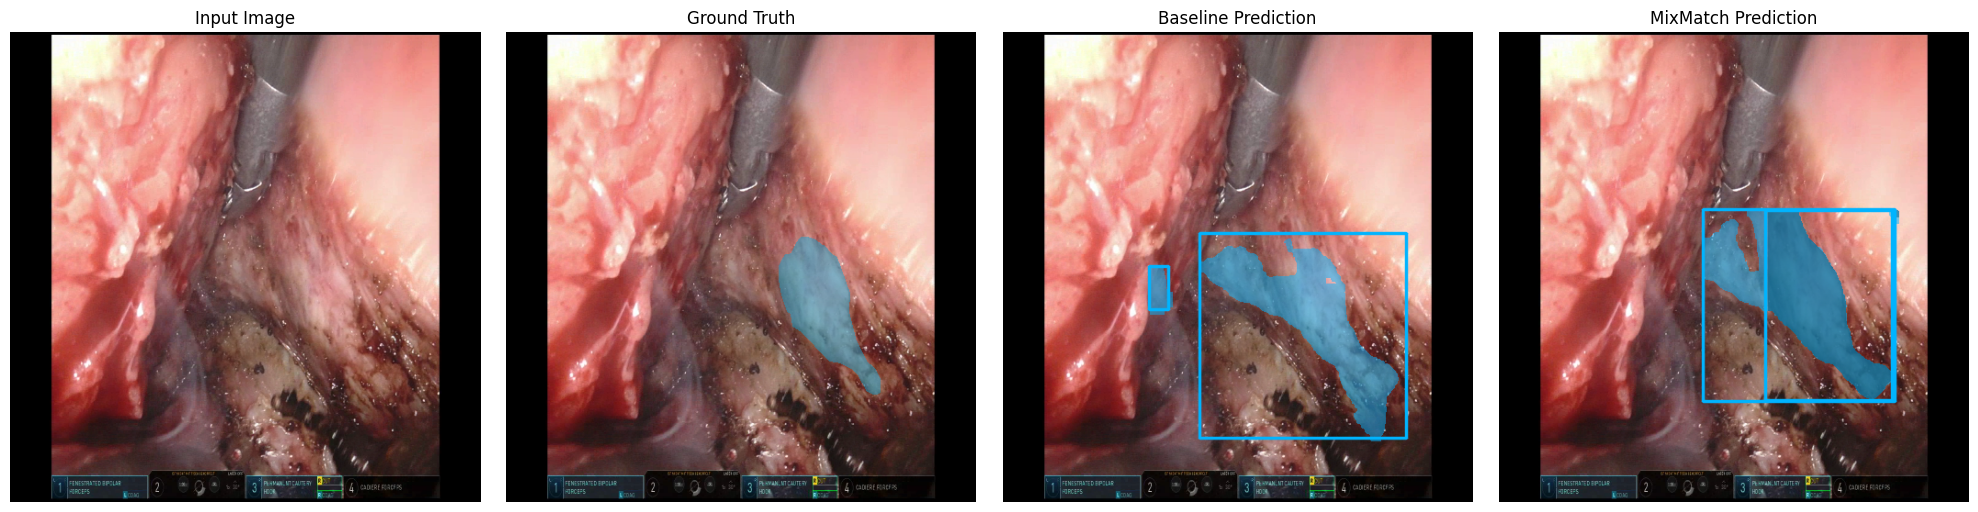

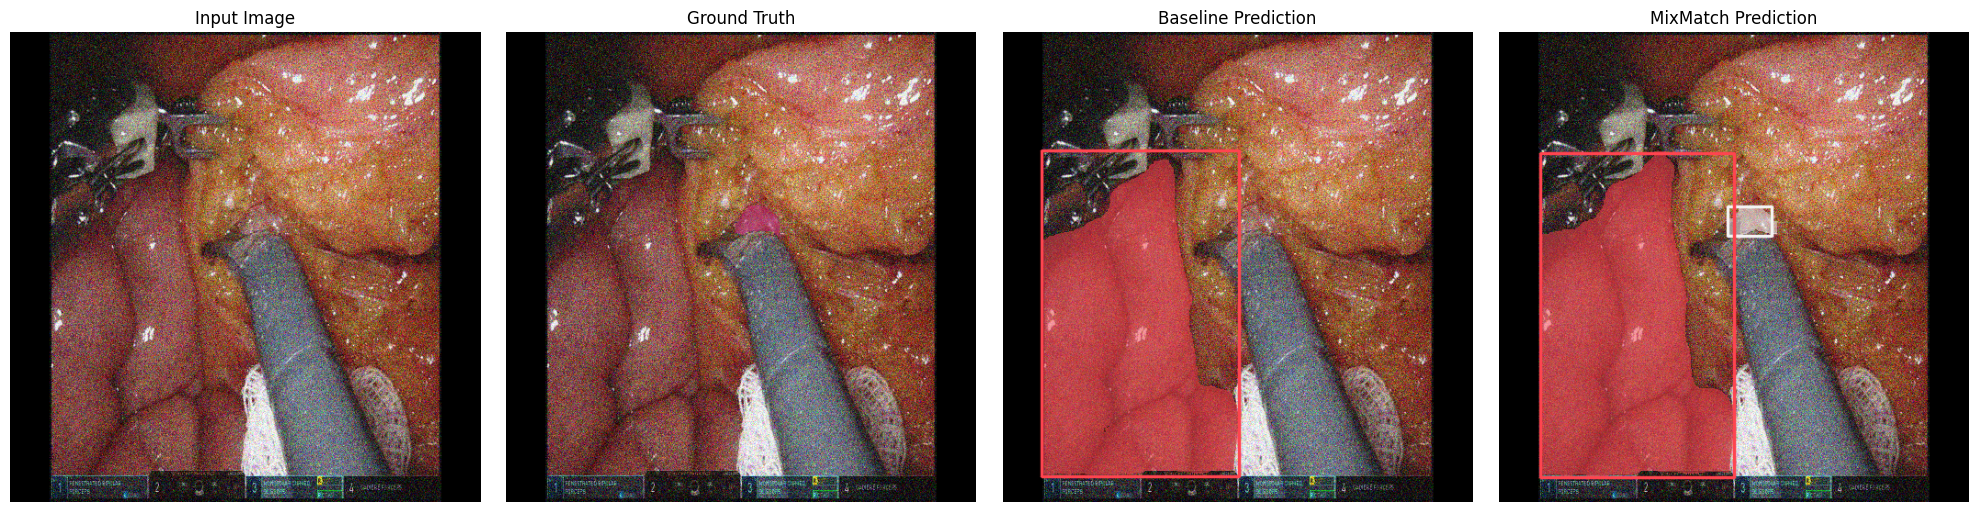

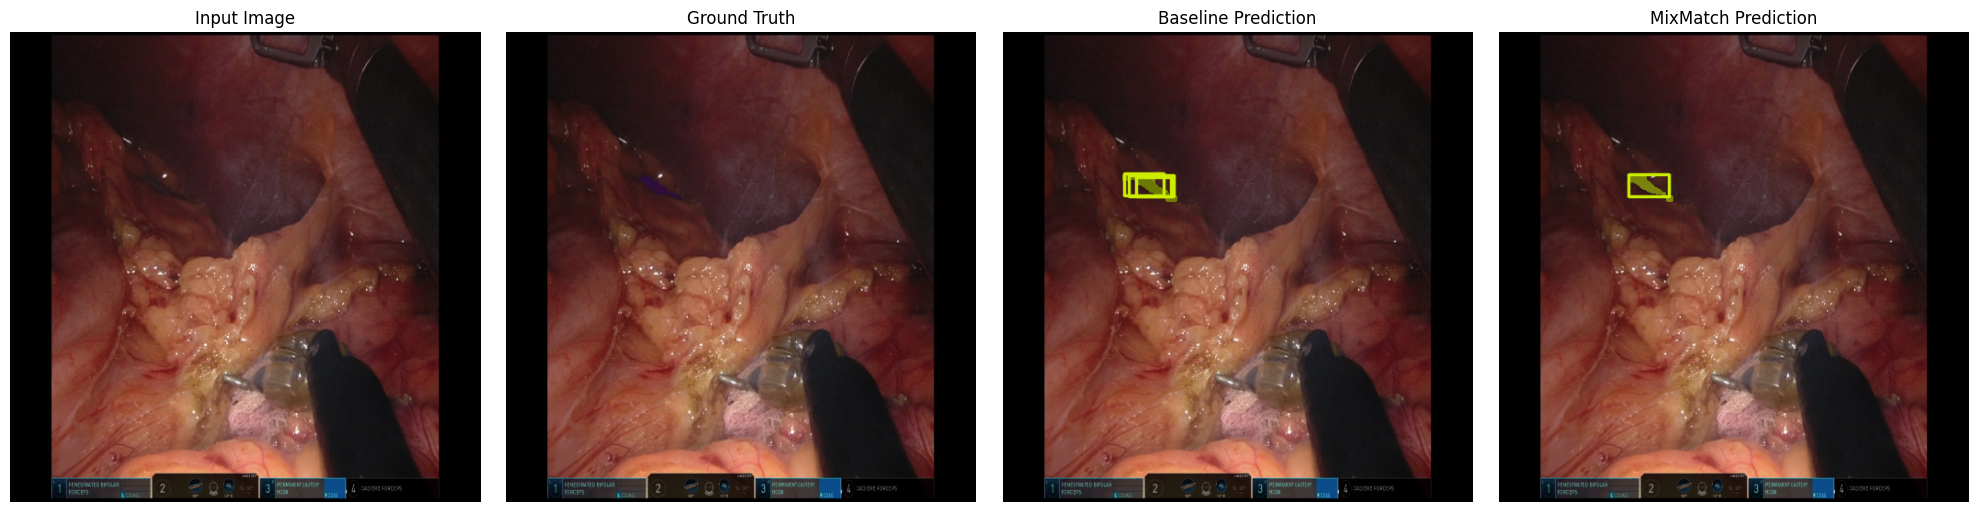

In [ ]:
import random
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Helper function to plot ground truth masks on an image
def plot_gt_masks_on_image(image_path, label_dir, class_names, colors=None):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Image not found at {image_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    label_filename = os.path.basename(image_path).replace('.jpg', '.txt').replace('.png', '.txt')
    full_label_path = os.path.join(label_dir, label_filename)

    overlay = img.copy()
    alpha = 0.5

    if os.path.exists(full_label_path):
        with open(full_label_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) < 3:
                    continue
                class_id = int(parts[0])
                coords = np.array([float(x) for x in parts[1:]]).reshape(-1, 2)
                coords[:, 0] *= w
                coords[:, 1] *= h

                if colors is None or class_id >= len(colors):
                    color = [random.randint(0, 255) for _ in range(3)]
                else:
                    color = colors[class_id]

                cv2.fillPoly(overlay, [coords.astype(np.int32)], color)

    return cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)


# Generate consistent colors
class_colors = None
if 'names' in data_yaml:
    np.random.seed(42)
    class_colors = [tuple(np.random.randint(0, 255, 3).tolist())
                    for _ in range(len(data_yaml['names']))]

# Visualizations
test_imgs = random.sample(test_images, 3)

for img_name in test_imgs:
    image_path = os.path.join('/kaggle/working/images/test', img_name)

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # 1. Input Image
    image = Image.open(image_path).convert("RGB")
    axes[0].imshow(image)
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    # 2. Ground Truth
    gt_image_with_masks = plot_gt_masks_on_image(
        image_path, '/kaggle/working/labels/test', data_yaml['names'], class_colors
    )
    axes[1].imshow(gt_image_with_masks if gt_image_with_masks is not None else image)
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')

    # 3. Baseline Prediction
    results_baseline = model_baseline.predict(image_path, verbose=False)
    if results_baseline and results_baseline[0].masks is not None:
        img_base = cv2.cvtColor(results_baseline[0].plot(labels=False, conf=False),
                                 cv2.COLOR_BGR2RGB)
        axes[2].imshow(img_base)
    else:
        axes[2].imshow(image)
    axes[2].set_title('Baseline Prediction')
    axes[2].axis('off')

    # 4. MixMatch Prediction  ✅ (ONLY CHANGE)
    results_mixmatch = model_mixmatch.predict(image_path, verbose=False)
    if results_mixmatch and results_mixmatch[0].masks is not None:
        img_mix = cv2.cvtColor(results_mixmatch[0].plot(labels=False, conf=False),
                                cv2.COLOR_BGR2RGB)
        axes[3].imshow(img_mix)
    else:
        axes[3].imshow(image)
    axes[3].set_title('MixMatch Prediction')
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()


## Discussion

Semi-supervised learning improves segmentation by leveraging unlabeled data, reducing the need for extensive annotations. Pseudo-labeling was effective but may introduce noise. Mean Teacher provided stable training through EMA. FixMatch excelled with augmentations. Unlabeled data helped in generalization. Challenges include hyperparameter tuning and computational cost.

## Conclusion

This notebook demonstrated SSL for instance segmentation, showing improvements over supervised baseline.